## 12. Exercise: Fashion MNIST Classification

**Your Task**: Adapt the CNN model we've built to classify the Fashion MNIST dataset.

The Fashion MNIST dataset consists of 28×28 grayscale images of 10 fashion categories:
- 0: T-shirt/top
- 1: Trouser
- 2: Pullover
- 3: Dress
- 4: Coat
- 5: Sandal
- 6: Shirt
- 7: Sneaker
- 8: Bag
- 9: Ankle boot

**Steps**:
1. Load the Fashion MNIST dataset instead of regular MNIST
2. Adapt the CNN model if necessary (you might want to use more filters or deeper architecture for this more complex dataset)
3. Train and evaluate the model
4. Visualize the results and compare with the digit classification results

**Hint**: You can load Fashion MNIST using `torchvision.datasets.FashionMNIST` instead of `datasets.MNIST`.

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torch.utils.data import random_split, DataLoader
from torchvision import datasets, transforms
from pytorch_lightning.callbacks import EarlyStopping

In [21]:


# Definizione delle trasformazioni per il Fashion MNIST
fashion_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.2860,), (0.3530,))  # Media e std di Fashion MNIST
])

# Definire i nomi delle classi per Fashion MNIST
fashion_class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                       'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [22]:
# DataModule per Fashion MNIST
class FashionMNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir="./data", batch_size=64):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.transform = fashion_transform

    def prepare_data(self):
        # Scarica il dataset se necessario (solo una volta)
        datasets.FashionMNIST(self.data_dir, train=True, download=True)
        datasets.FashionMNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        # Assegna i dataset per train, validazione e test
        if stage == "fit" or stage is None:
            fashion_full = datasets.FashionMNIST(self.data_dir, train=True, transform=self.transform)
            self.fashion_train, self.fashion_val = random_split(fashion_full, [55000, 5000])

        if stage == "test" or stage is None:
            self.fashion_test = datasets.FashionMNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.fashion_train, batch_size=self.batch_size, shuffle=True, num_workers=4)

    def val_dataloader(self):
        return DataLoader(self.fashion_val, batch_size=self.batch_size, num_workers=4)

    def test_dataloader(self):
        return DataLoader(self.fashion_test, batch_size=self.batch_size, num_workers=4)


In [23]:
class FashionMNISTClassifierCNN(pl.LightningModule):
    def __init__(self, hidden_size=32, learning_rate=0.001):
        super().__init__()
        self.save_hyperparameters()

        # Layer convoluzionali
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)

        # Pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Calcolare la dimensione dei dati dopo i layer convoluzionali e pooling
        self.fc_input_size = 64 * 7 * 7

        # Layer completamente connessi
        self.fc1 = nn.Linear(self.fc_input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 10)  # 10 classi per Fashion MNIST

        # Dropout
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = F.relu(self.conv1(x))  # Shape: [batch_size, 16, 28, 28]
        x = self.pool(x)           # Shape: [batch_size, 16, 14, 14]

        x = F.relu(self.conv2(x))  # Shape: [batch_size, 32, 14, 14]
        x = self.pool(x)           # Shape: [batch_size, 32, 7, 7]

        x = x.view(-1, self.fc_input_size)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)  # Shape: [batch_size, 10]
        
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)

        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)

        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)

        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", acc, prog_bar=True)

        return {"test_loss": loss, "test_acc": acc, "preds": preds, "targets": y}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        return optimizer


In [24]:
# Setup del DataModule per Fashion MNIST
fashion_data_module = FashionMNISTDataModule(batch_size=128)

# Creazione del modello Fashion MNIST CNN
fashion_model = FashionMNISTClassifierCNN(hidden_size=128, learning_rate=0.001)

# Funzione di addestramento e valutazione
def train_and_evaluate(model, model_name, max_epochs=5):
    # Early stopping
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3,
        verbose=True,
        mode='min'
    )

    # Trainer
    trainer = pl.Trainer(
        max_epochs=max_epochs,
        callbacks=[early_stopping],
        accelerator='auto',
        logger=True,
    )

    # Addestra il modello
    print(f"\nTraining {model_name}...")
    trainer.fit(model, fashion_data_module)

    # Testa il modello
    print(f"\nTesting {model_name}...")
    test_results = trainer.test(model, fashion_data_module)

    return model, test_results

# Avvio dell'addestramento
cnn_model, cnn_results = train_and_evaluate(fashion_model, "Fashion MNIST CNN", max_epochs=10)


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type      | Params | Mode 
----------------------------------------------
0 | conv1   | Conv2d    | 320    | train
1 | conv2   | Conv2d    | 18.5 K | train
2 | pool    | MaxPool2d | 0      | train
3 | fc1     | Linear    | 401 K  | train
4 | fc2     | Linear    | 1.3 K  | train
5 | dropout | Dropout   | 0      | train
----------------------------------------------
421 K     Trainable params
0         Non-trainable params
421 K     Total params
1.687     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



Training Fashion MNIST CNN...
Epoch 0: 100%|███████████████████████████████████████████████████████████████████| 430/430 [00:50<00:00,  8.53it/s, v_num=11, train_loss=0.407, train_acc=0.864]
idation: |                                                                                                                             | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|████████████████████████████████████| 430/430 [01:03<00:00,  6.72it/s, v_num=11, train_loss=0.407, train_acc=0.864, val_loss=0.320, val_acc=0.883]

Metric val_loss improved. New best score: 0.320


Epoch 1: 100%|████████████████████████████████████| 430/430 [01:16<00:00,  5.61it/s, v_num=11, train_loss=0.341, train_acc=0.864, val_loss=0.320, val_acc=0.883]
idation: |                                                                                                                             | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|████████████████████████████████████| 430/430 [01:28<00:00,  4.88it/s, v_num=11, train_loss=0.341, train_acc=0.864, val_loss=0.267, val_acc=0.902]

Metric val_loss improved by 0.053 >= min_delta = 0.0. New best score: 0.267


Epoch 2: 100%|████████████████████████████████████| 430/430 [01:13<00:00,  5.86it/s, v_num=11, train_loss=0.323, train_acc=0.932, val_loss=0.267, val_acc=0.902]
idation: |                                                                                                                             | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|████████████████████████████████████| 430/430 [01:24<00:00,  5.06it/s, v_num=11, train_loss=0.323, train_acc=0.932, val_loss=0.250, val_acc=0.909]

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.250


Epoch 3: 100%|████████████████████████████████████| 430/430 [01:11<00:00,  6.00it/s, v_num=11, train_loss=0.238, train_acc=0.898, val_loss=0.250, val_acc=0.909]
idation: |                                                                                                                             | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|████████████████████████████████████| 430/430 [01:23<00:00,  5.13it/s, v_num=11, train_loss=0.238, train_acc=0.898, val_loss=0.224, val_acc=0.918]

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 0.224


Epoch 4: 100%|████████████████████████████████████| 430/430 [01:14<00:00,  5.74it/s, v_num=11, train_loss=0.247, train_acc=0.932, val_loss=0.224, val_acc=0.918]
idation: |                                                                                                                             | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|████████████████████████████████████| 430/430 [01:26<00:00,  4.95it/s, v_num=11, train_loss=0.247, train_acc=0.932, val_loss=0.215, val_acc=0.920]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.215


Epoch 5: 100%|████████████████████████████████████| 430/430 [01:16<00:00,  5.60it/s, v_num=11, train_loss=0.221, train_acc=0.909, val_loss=0.215, val_acc=0.920]
idation: |                                                                                                                             | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|████████████████████████████████████| 430/430 [01:28<00:00,  4.83it/s, v_num=11, train_loss=0.221, train_acc=0.909, val_loss=0.208, val_acc=0.924]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.208


Epoch 6: 100%|████████████████████████████████████| 430/430 [01:11<00:00,  5.97it/s, v_num=11, train_loss=0.235, train_acc=0.898, val_loss=0.208, val_acc=0.924]
idation: |                                                                                                                             | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|████████████████████████████████████| 430/430 [01:23<00:00,  5.16it/s, v_num=11, train_loss=0.235, train_acc=0.898, val_loss=0.203, val_acc=0.927]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.203


Epoch 7: 100%|████████████████████████████████████| 430/430 [01:13<00:00,  5.82it/s, v_num=11, train_loss=0.177, train_acc=0.920, val_loss=0.203, val_acc=0.927]
idation: |                                                                                                                             | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|████████████████████████████████████| 430/430 [01:17<00:00,  5.55it/s, v_num=11, train_loss=0.139, train_acc=0.966, val_loss=0.205, val_acc=0.924]
idation: |                                                                                                                             | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|████████████████████████████████████| 430/430 [01:23<00:00,  5.13it/s, v_num=11, train_loss=0.252, train_acc=0.909, val_loss=0.205, val_acc=0.925]
idation: |                                                                                                                             | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|█████████████████████████████

Monitored metric val_loss did not improve in the last 3 records. Best score: 0.203. Signaling Trainer to stop.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|████████████████████████████████████| 430/430 [01:37<00:00,  4.40it/s, v_num=11, train_loss=0.252, train_acc=0.909, val_loss=0.218, val_acc=0.924]

Testing Fashion MNIST CNN...
Testing DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 14.47it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9204999804496765     │
│         test_loss         │    0.25018754601478577    │
└───────────────────────────┴───────────────────────────┘

Predizioni del modello CNN:


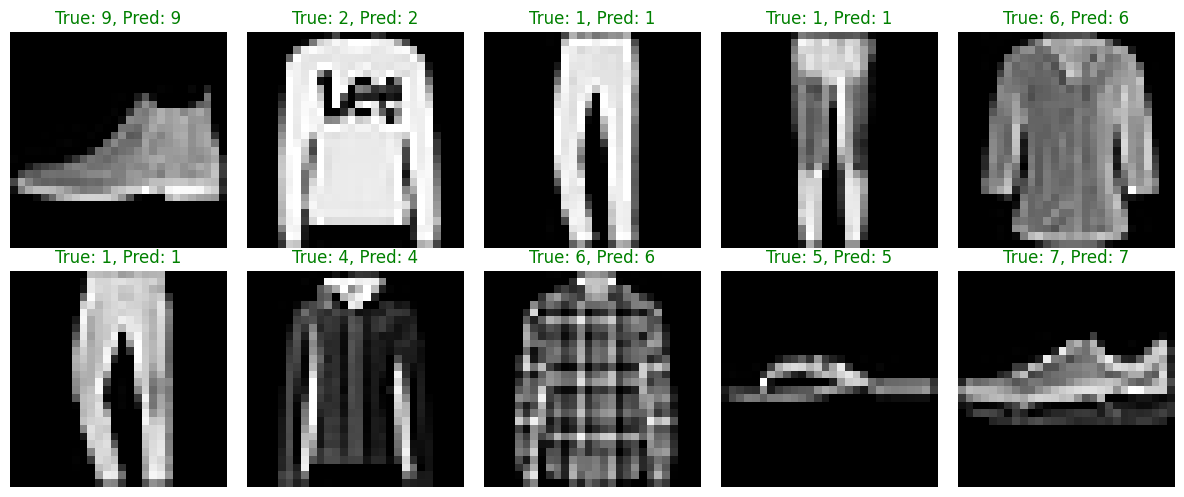

In [25]:
# TODO: Visualize some predictions and analyze the results
def show_predictions(model, num_samples=10):
    # batch di dati di test
    test_loader = fashion_data_module.test_dataloader()
    batch = next(iter(test_loader))
    images, labels = batch

    # predizioni
    model.eval()
    with torch.no_grad():
        logits = model(images)
        preds = torch.argmax(logits, dim=1)

    # immagini con le predizioni
    fig, axes = plt.subplots(2, 5, figsize=(12, 5))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        img = images[i].squeeze().cpu().numpy()
        label = labels[i].item()
        pred = preds[i].item()

        ax.imshow(img, cmap='gray')
        title_color = 'green' if pred == label else 'red'
        ax.set_title(f'True: {label}, Pred: {pred}', color=title_color)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# predizioni del modello CNN
print("Predizioni del modello CNN:")
show_predictions(cnn_model)


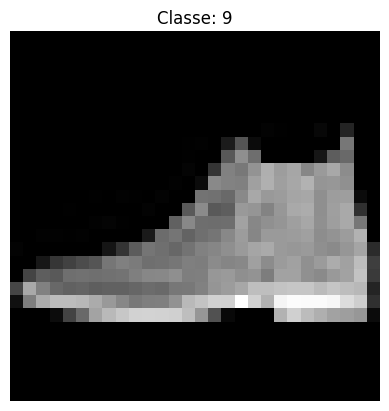

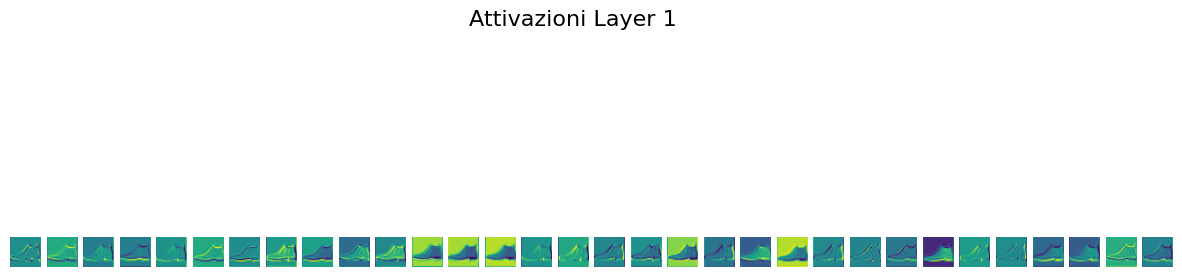

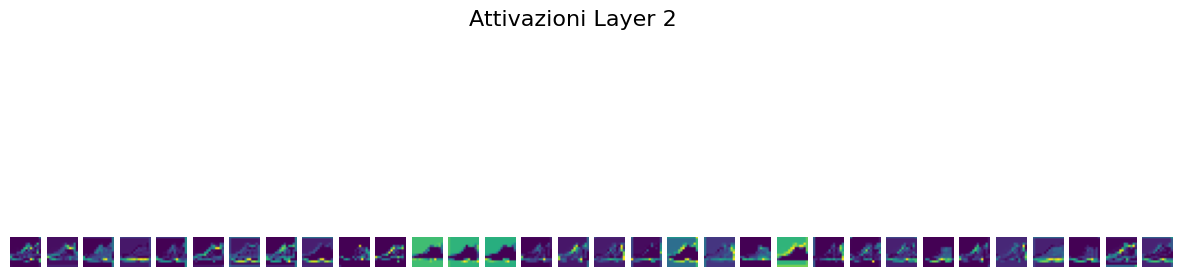

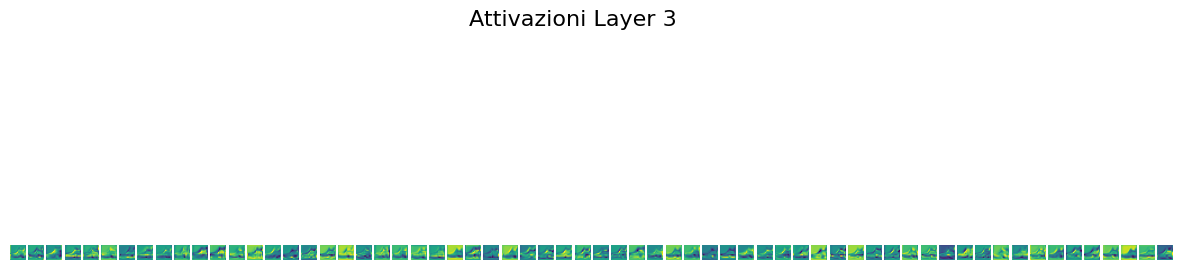

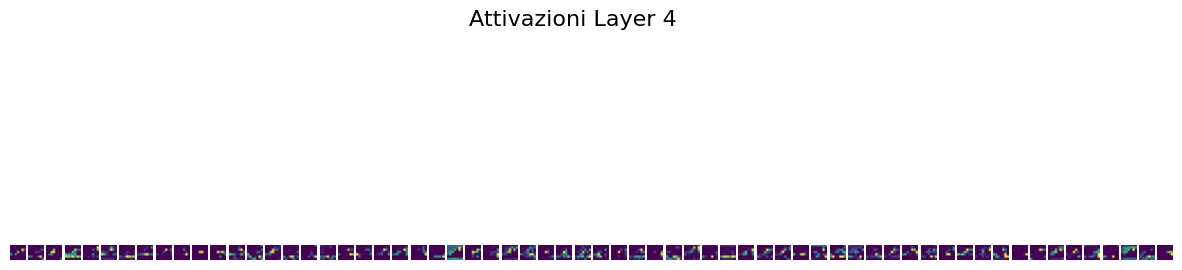

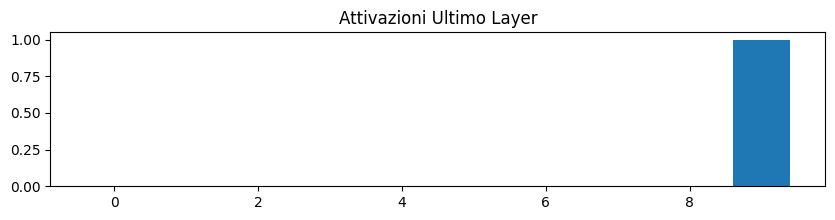

In [26]:
def visualize_cnn_layers(model, image):
    """
    Visualizza le attivazioni di tutti i layer di un modello CNN per una singola immagine di input.
    """
    model.eval()  # Imposta il modello in modalità di valutazione
    activations = []  # Lista per memorizzare le attivazioni
    hooks = []  # Lista per memorizzare i hook dei layer

    # Funzione hook per catturare le attivazioni
    def hook_fn(module, input, output):
        activations.append(output)

    # Registriamo hook per ogni layer convoluzionale e pooling
    for layer in model.children():
        if isinstance(layer, (nn.Conv2d, nn.MaxPool2d, nn.Linear)):
            hooks.append(layer.register_forward_hook(hook_fn))

    # Passaggio attraverso il modello (senza calcolare i gradienti)
    with torch.no_grad():
        _ = model(image.unsqueeze(0))  # Aggiungi dimensione del batch

    # Visualizzare le attivazioni dei layer convoluzionali
    for i, activation in enumerate(activations):
        if len(activation.shape) == 4:  # Per i layer convoluzionali o di pooling
            num_filters = activation.shape[1]  # Numero di filtri nel layer
            fig, axes = plt.subplots(1, num_filters, figsize=(15, 5))
            fig.suptitle(f"Attivazioni Layer {i + 1}", fontsize=16)
            for j in range(num_filters):
                ax = axes[j]
                ax.imshow(activation[0, j].cpu().numpy(), cmap="viridis")  # Visualizza ogni filtro
                ax.axis("off")

    # attivazioni dell'ultimo layer fully connected (softmax)
    plt.figure(figsize=(10, 2))
    plt.title("Attivazioni Ultimo Layer")
    a = activations[-1][0].cpu().numpy()  # Ultima attivazione (output della rete)
    a = torch.softmax(torch.tensor(a), dim=0).numpy()  #softmax per ottenere probabilità
    plt.bar(x=range(len(a)), height=a)
    plt.show()

    # Rimuovo gli hook dopo l'uso
    for hook in hooks:
        hook.remove()

def visualize_test_image_and_activations(model, test_loader):
    # considero un esempio dal test set
    data_iter = iter(test_loader)
    images, labels = next(data_iter)

    #la prima immagine per la visualizzazione
    image = images[0]  # Usa la prima immagine dal batch

    # Visualizz
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f"Classe: {labels[0].item()}")
    plt.axis('off')
    plt.show()

    # Visualizzo le attivazioni della CNN per questa immagine
    visualize_cnn_layers(model, image)

# Visualizzo un'immagine del test set e le attivazioni della CNN
visualize_test_image_and_activations(cnn_model, fashion_data_module.test_dataloader())

## Modello Convoluzionale per il Dataset Fashion MNIST

In questo notebook, ho implementato un modello di rete neurale convoluzionale (CNN) utilizzando **PyTorch** e **PyTorch Lightning** per classificare le immagini del dataset **Fashion MNIST**. 

### 1. Preprocessing dei Dati

Nel modulo `FashionMNISTDataModule` carico e trasformo i dati. Immagini convertite in tensori e normalizzate con valori di media e deviazione standard specifici per il dataset Fashion MNIST.

### 2. Definizione del Modello CNN

Il modello `FashionMNISTClassifierCNN` utilizza la funzione di attivazione ReLU e il dropout per la regolarizzazione.

- **Struttura del modello**:
  - Layer convoluzionali con `ReLU` e pooling.
  - Fully connected layers.
  - Funzione di perdita: `CrossEntropyLoss` per la classificazione multiclasse.
  - Ottimizzatore: Adam con un tasso di apprendimento di 0.001.

### 3. Allenamento e Valutazione

Il modello viene allenato per un massimo di 10 epoche, utilizzando il modulo di early stopping per interrompere l'allenamento se la perdita di validazione non migliora dopo 3 epoche. Alla fine dell'allenamento, il modello viene testato sui dati di test.

### 4. Visualizzazione delle Predizioni

Al termine dell'allenamento, vengono visualizzate alcune immagini di test insieme alle predizioni del modello, per confrontare le etichette vere con quelle previste.

### 5. Visualizzazione delle Attivazioni

Dopo aver scelto un'immagine dal test set, visualizzo le attivazioni di ciascun layer convoluzionale e il risultato dell'ultimo layer fully connected (softmax). La visualizzazione mostra le attivazioni come immagini dei filtri per i layer convoluzionali e un grafico delle probabilità per l'output finale.


L'accuratezza elevata (92.07%) e la perdita relativamente bassa (0.240) suggeriscono che il modello sta funzionando molto bene sul set di test